In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  silhouette_samples, silhouette_score 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


## Read data

In [2]:
file = '/Users/1/Documents/bl_fr/BlackFriday.csv'
bf = pd.read_csv(file)

## Fill in missing values

In [3]:
bf['Product_Category_3'].fillna(0, inplace=True)
bf['Product_Category_2'].fillna(0, inplace=True)

## Data preperation(for clustering)

In [4]:
users_purchase_group = bf.groupby('User_ID')[['Purchase']].sum()
users_purchase_group.columns = ['Purchase_sum'] 


info = ['Gender', 'Age', 'Occupation', 'City_Category', 
        'Stay_In_Current_City_Years', 'Marital_Status']

users_info_group = bf.groupby('User_ID')[info].max()

users_unique_product_group = bf.groupby('User_ID')[['Product_ID']].nunique()
users_unique_product_group.columns = ['Unique_Products']

usr_vs_product = bf.groupby(['User_ID', 'Product_ID'])[['Product_ID']].count().unstack()
usr_vs_product.fillna(0, inplace=True)
usr_vs_product['Freq_Product'] = usr_vs_product.idxmax(axis=1)
usr_vs_product['Freq_Product'] = usr_vs_product['Freq_Product'].apply(lambda x: x[1])

usr_vs_cat = bf.groupby(['User_ID', 'Product_Category_1'])[['Product_Category_1']].count().unstack()
usr_vs_cat.fillna(0, inplace=True)
usr_vs_cat['Freq_Cat'] = usr_vs_cat.idxmax(axis=1)
usr_vs_cat['Freq_Cat'] = usr_vs_cat['Freq_Cat'].apply(lambda x: x[1])

prod = bf[['Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]
prod.drop_duplicates(inplace=True)
prod['Addional_Cat'] = prod.apply(lambda x: True if (x['Product_Category_2']!=0) or (x['Product_Category_3']!=0) else False, axis=1)
prod.drop(['Product_Category_1', 'Product_Category_2', 'Product_Category_3'], axis=1, inplace=True)


bf = bf.merge(prod, on='Product_ID')


adds_cat = bf.groupby(['User_ID', 'Addional_Cat'])[['Addional_Cat']].count().unstack()


# number of products that user buy and that have adiitional category
cat_23_s = adds_cat[('Addional_Cat',  True)].rename('Addional_Cat')

# total transactions 
tranact_amount = bf.groupby(['User_ID'])['User_ID'].count().rename('Total_transactions')

# Combine all created features
users = pd.concat([users_info_group, users_unique_product_group, usr_vs_product['Freq_Product'], 
           usr_vs_cat['Freq_Cat'], cat_23_s, users_purchase_group, tranact_amount], axis=1)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## EDA

In [5]:
users['Gender'].value_counts(normalize=True)

M    0.717196
F    0.282804
Name: Gender, dtype: float64

Male clients are the majority of the mall customer

In [6]:
users['Age'].value_counts(normalize=True)

26-35    0.348498
36-45    0.198099
18-25    0.181463
46-50    0.090137
51-55    0.081650
55+      0.063147
0-17     0.037006
Name: Age, dtype: float64

We can see that we have 3 main categories by age: 
<ul> 
    <li>26-35</li>
    <li>36-45</li>
    <li>18-25</li>
</ul>
Older and young people have a less than 10 percent like separate categories and near 17 percent in general

In [7]:
users['City_Category'].value_counts(normalize=True)

C    0.532847
B    0.289764
A    0.177389
Name: City_Category, dtype: float64

<p style="font-size:18px;"> a little bit more, than a half of clients are from city C</p>

In [8]:
users['Stay_In_Current_City_Years'].value_counts(normalize=True)

1     0.354099
2     0.194364
3     0.166186
4+    0.154303
0     0.131047
Name: Stay_In_Current_City_Years, dtype: float64

- 35 % percent of clients live in their own city for 1 year
- the least group of people that have just moved(13 %)

In [9]:
users['Marital_Status'].value_counts(normalize=True)

0    0.580037
1    0.419963
Name: Marital_Status, dtype: float64

We have almost balanced dataset by marital status, 
but we have 17 percent more unmarried people.

In [10]:
users.groupby(['City_Category', 'Stay_In_Current_City_Years'])['Stay_In_Current_City_Years'].count()

City_Category  Stay_In_Current_City_Years
A              0                              147
               1                              370
               2                              183
               3                              180
               4+                             165
B              0                              211
               1                              608
               2                              342
               3                              295
               4+                             251
C              0                              414
               1                             1108
               2                              620
               3                              504
               4+                             493
Name: Stay_In_Current_City_Years, dtype: int64

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


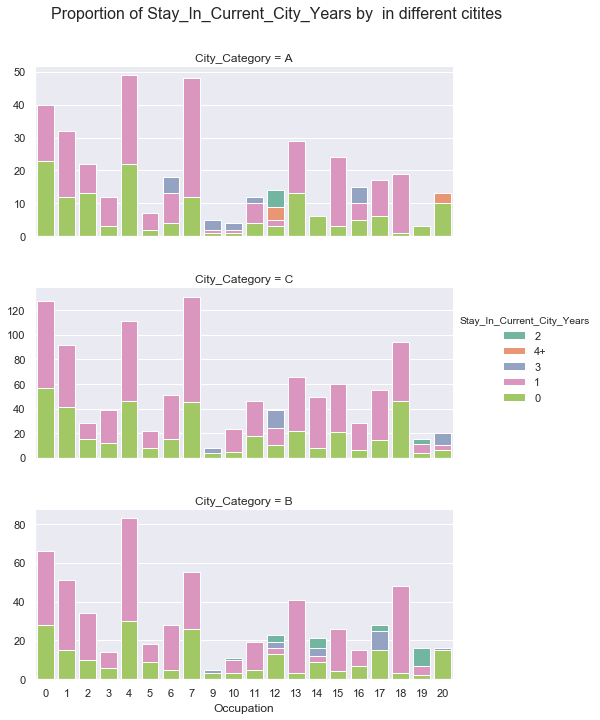

In [11]:
sns.set_context("talk", font_scale=3.4)

sns.set(rc={'figure.figsize':(15,10), 'font.size': 32})
g = sns.FacetGrid(users,row="City_Category",
                   hue="Stay_In_Current_City_Years", palette='Set2', aspect=2, height=3.5, sharey=False)
g = (g.map(sns.countplot, "Occupation")).add_legend()   
plt.subplots_adjust(top=.9)
g.fig.suptitle("Proportion of Stay_In_Current_City_Years by  in different citites", fontsize=16)

plt.show()

__Insights__:
- in all cities the most popular occupation categories are 0, 1, 4, 7,18
- City C have the highest population
- People, that just moved(Stay_In_Current_City_Years= 0) make up a significant part in all occupation categories
- People, that live in the current city for a one year prefer popular categories of occupation(actually this group of people make that categories popular cause of 35% of clients presented in dataset belong to this class :) ), as well as 13, 15
- People that live in the current city more than 3 year prefer works in 9 cat. for all cities; 
- people that live for 2 years in current city make up a significant part in 12 category in city A; prefer 4 different categories in city C and almost absent in city B and prefer only one category; 
- significant part of people 4+ year prefer 20 and 12 category in city A

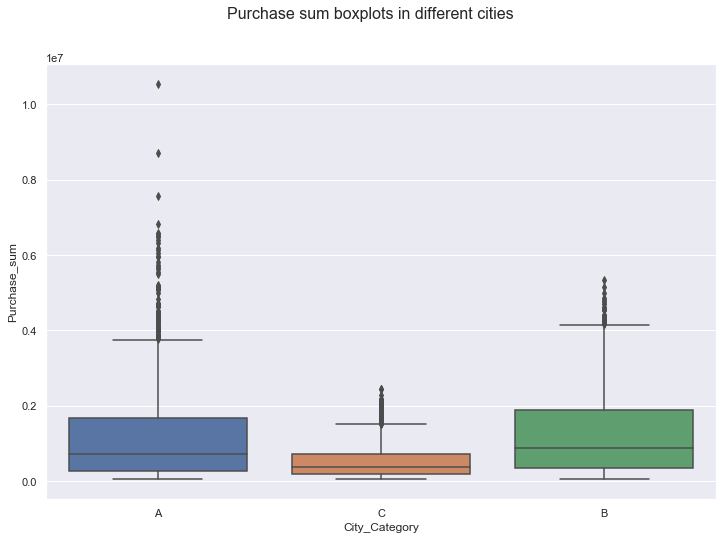

In [12]:
fig = plt.figure(figsize=(12, 8))
sns.boxplot(x="City_Category", y="Purchase_sum", data=users)
fig.suptitle("Purchase sum boxplots in different cities", fontsize=16)
plt.show()

__Insights__:

- C city have the lowest have the lowest median purchase sum 
- B and A city have more wider interqualiative range  than city C
- A city have much more outliers than others

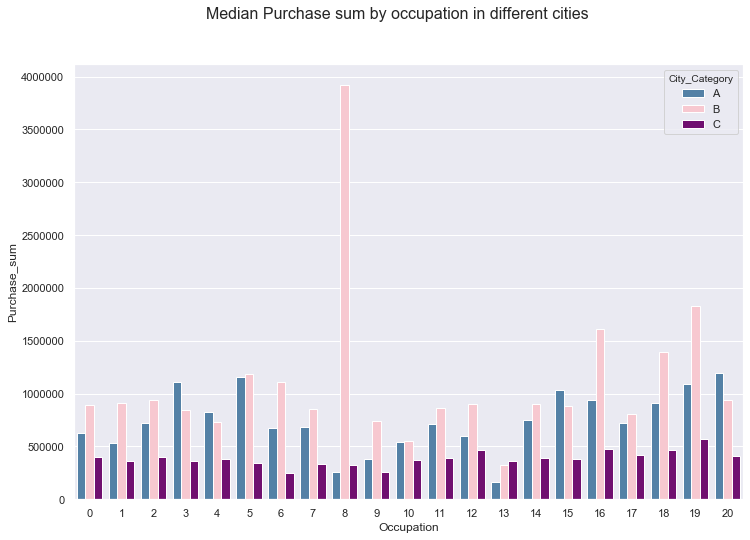

In [13]:
fig = plt.figure(figsize=(12, 8))
colors = ['steelblue', 'pink', 'purple']
gr = users.groupby(["City_Category", "Occupation"])[["Purchase_sum"]].median().reset_index()

sns.barplot(x="Occupation", y="Purchase_sum", data=gr, hue="City_Category", palette= sns.set_palette(colors))
fig.suptitle("Median Purchase sum by occupation in different cities", fontsize=16)
plt.show() 

__Insights__: 

- in all occupation categories except 13; city B have the highest median purchase sum

- (B, A, C); all except 13

- 8 occupation in city B - the highest !

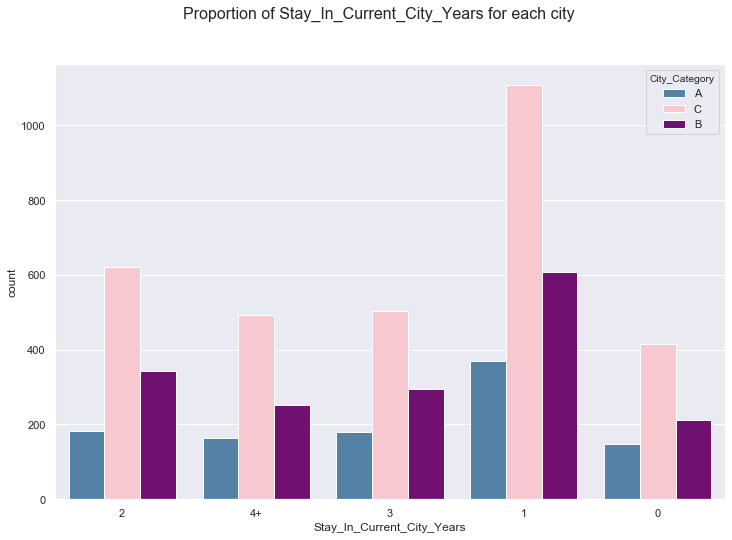

In [14]:
fig = plt.figure(figsize=(12, 8))
sns.countplot(x="Stay_In_Current_City_Years", data=users, hue="City_Category")
fig.suptitle("Proportion of Stay_In_Current_City_Years for each city", fontsize=16)
plt.show()

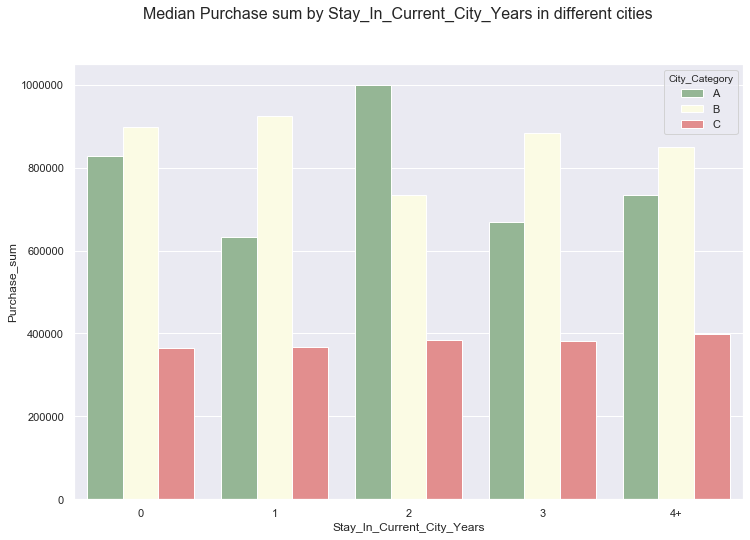

In [15]:
fig = plt.figure(figsize=(12, 8))
colors = ['darkseagreen', 'lightyellow', 'lightcoral']
gr = users.groupby(["City_Category", "Stay_In_Current_City_Years"])[["Purchase_sum"]].median().reset_index()

sns.barplot(x="Stay_In_Current_City_Years", y="Purchase_sum", data=gr, hue="City_Category", palette= sns.set_palette(colors))
fig.suptitle("Median Purchase sum by Stay_In_Current_City_Years in different cities", fontsize=16)
plt.show()

__Insights__:

- People that live in city 0 and 2 year from city A have higher median Purchase_sum than other cities; 

- People that live in city 1,3,4+ year from city B have higher median Purchase_sum than people from other cities in the same "years" category

- Purchase_sum Median of city C in all "years" categories have lower variance the another cities

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


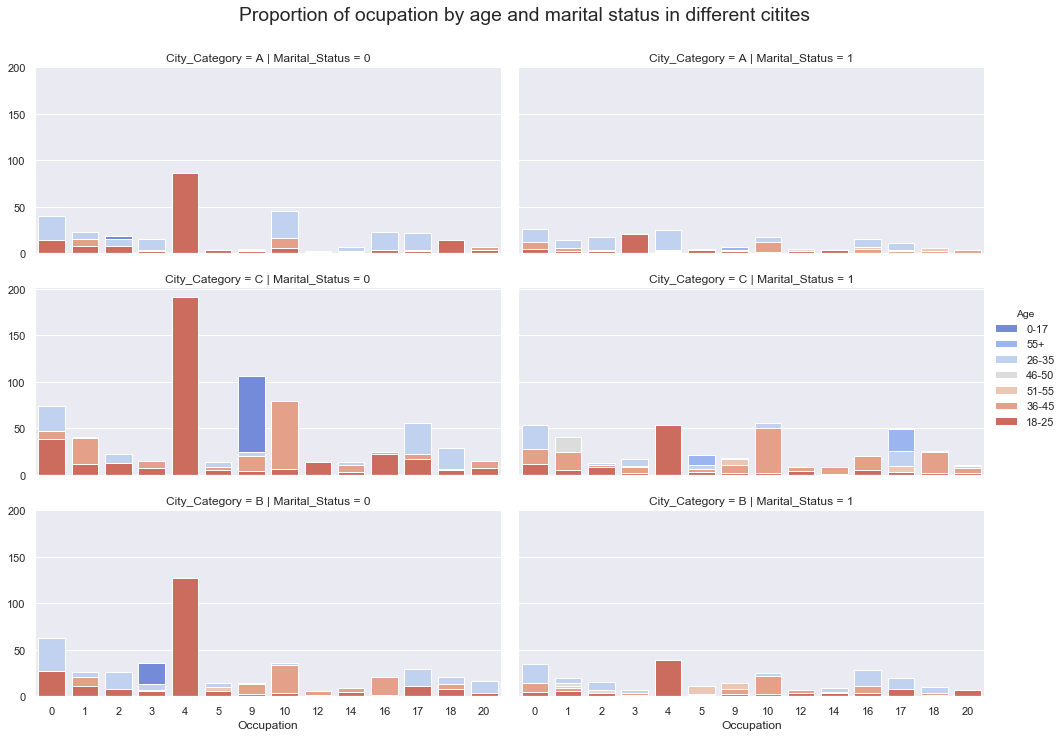

In [16]:
sns.set_context("talk", font_scale=3.4)

sns.set(rc={'figure.figsize':(15,10), 'font.size': 16})
g = sns.FacetGrid(users,row="City_Category", col="Marital_Status",
                   hue="Age", palette='coolwarm', aspect=2, height=3.5)
g = (g.map(sns.countplot, "Occupation")).add_legend()  
plt.subplots_adjust(top=.9)
g.fig.suptitle("Proportion of ocupation by age and marital status in different citites")
plt.show()

__Insights__:

- Regardless to city and marital status age category 18-25  make up a significant part 4 occupation category 

- Unmarried underage(0-17) people  make up a significant part 9 occupation category in C city; 

- City A have less married people than in other cities; 

- 10th occupation category  is popular among people of age 51-55 

- It seems to be that City B has some kind of demographic balance in compare with city A, where 26-35 age category is the most common the same story with 36-45 and 18-25 age category in city C

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


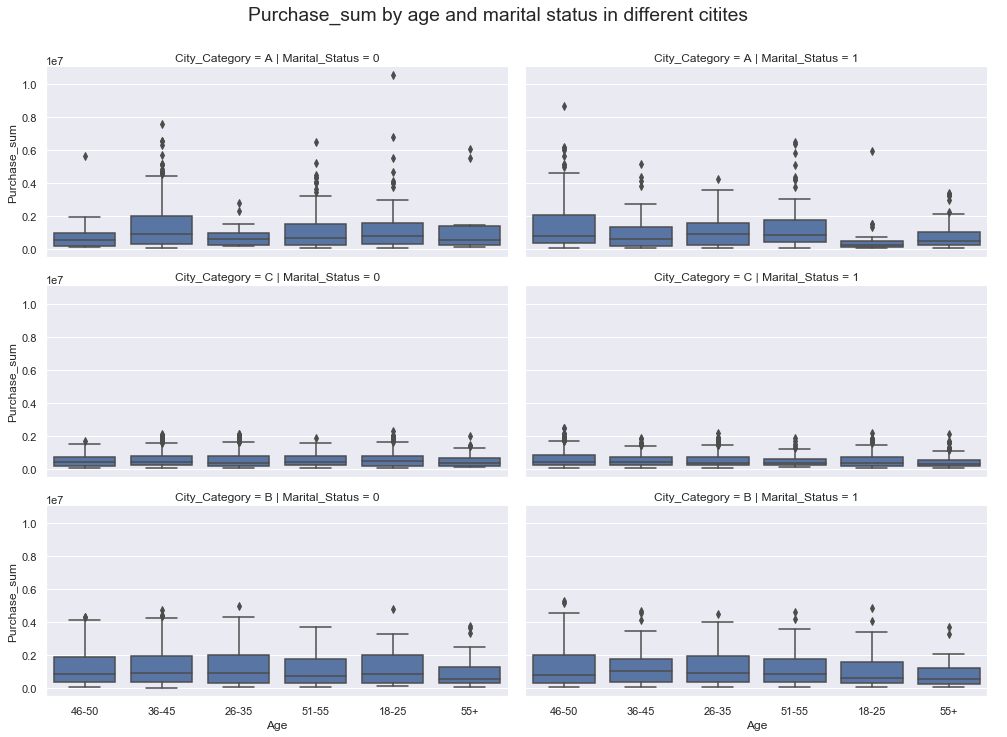

In [17]:
sns.set_context("talk", font_scale=3.4)

sns.set(rc={'figure.figsize':(15,10), 'font.size': 16})
g = sns.FacetGrid(users,row="City_Category", col= "Marital_Status",
                    aspect=2, height=3.5)
g = (g.map(sns.boxplot, "Age","Purchase_sum")).add_legend()  
plt.subplots_adjust(top=.9)
g.fig.suptitle("Purchase_sum by age and marital status in different citites")
plt.show()

## Transform data(for clustering)

In [18]:
users['Stay_In_Current_City_Years'] = users['Stay_In_Current_City_Years'].apply(lambda x: int(x[0]) if x == '4+' else int(x))

# 1 - M; 0 - F
users['Gender'] = users['Gender'].apply(lambda x: 1 if x == 'M' else 0).astype('category')

city_dict = {'A': 0, 'B': 1, 'C': 2}
users['City_Category'] = users['City_Category'].map(city_dict)

age_dict = {'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3,
            '46-50': 4, '51-55': 5, '55+': 6}
users['Age'] = users['Age'].map(age_dict)

users['Freq_Product'] = LabelEncoder().fit_transform(users['Freq_Product'])


## Data Normalization

In [19]:
X_std = StandardScaler().fit_transform(users)


## Clustering functions

In [20]:
def count_in_clusters(column, cluster_labels_col,data,ax): 
    ax = sns.countplot(x=column, data=data, hue=cluster_labels_col,ax=ax)
    ax.set_title(column+" in diff clusters")
    return ax

def box_plot_in_clusters(column,labels_col,  data,ax): 
    ax = sns.boxplot(x=labels_col, y=column, data=data,ax=ax)
    ax.set_title(column+"distr in diff clusters")
    return ax

def pca(c): 
    pca = PCA(n_components=c)
    X = pca.fit_transform(X_std)
    return X

def do_clustering(n_cl, c): 
    X = pca(c)
    km = KMeans(n_clusters = n_cl, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X)
    labels = km.labels_
    sse = km.inertia_
    centroids = km.cluster_centers_
    return (labels, sse, centroids) 

def plot_clustering_results(data): 
    
    cols_count = ['Gender', 'Age', 'Occupation', 'City_Category', 
                 'Stay_In_Current_City_Years', 'Marital_Status']
    
    cols_box = ['Purchase_sum', 'Unique_Products', 'Addional_Cat']              
                  
    fig, axs = plt.subplots(3,3, figsize=(20,20))
                  
    for i, ax in enumerate(fig.axes): 
        if i<=2: 
            ax = box_plot_in_clusters(cols_box[i], 'labels', data,ax)
        else: 
            ax = count_in_clusters(cols_count[i-3],'labels', data,ax)
    
    fig.suptitle("Clustering result with %d clusers" % len(data.labels.unique()))              
    plt.show()


def silhouette_mean_score(labels): 
    silhouette_vals = silhouette_samples(X_std, labels)
    return np.mean(silhouette_vals)

In [21]:
def try_diff_cluster_num_and_pca_component(n_clusters, n_components): 
    result = do_clustering(n_cl=n_clusters, c=n_components)
    labels = result[0]
    s = pd.Series(labels, index=users.index, name='labels')
    cl_users = pd.concat([users, s], axis=1)
    plot_clustering_results(cl_users)

def clustering_no_pca(n): 
    km = KMeans(n_clusters = n, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X_std)
    labels = km.labels_
    sse = km.inertia_
    centroids = km.cluster_centers_
    return (labels, sse, centroids)


## PCA explained variance

In [54]:
pca = PCA(n_components=9)
X = pca.fit_transform(X_std)

print(pca.explained_variance_ratio_)

[0.36053833 0.11587294 0.10639401 0.08328546 0.07676073 0.07123638
 0.06754896 0.06194141 0.053226  ]


## Elbow method and Silhouette analysis:

In [48]:
def clustering_effectiveness_pca(n_components, color):
    sse = []
    list_k = list(range(2, 10))

    for k in list_k: 
        results = do_clustering(n_cl=k, c=n_components)
        labels = results[0]
        sse_k = results[1]
        sse.append(sse_k)
        score = silhouette_mean_score(labels)
        print("Silhouette score for %d clusers:" % k + str(score))
    
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o', color=color)
    plt.title('With dimensionality reduction (%d pca components)' % n_components)
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance');

def clustering_effectiveness(): 
    sse = []
    list_k = list(range(2, 10))

    for k in list_k: 
        results = clustering_no_pca(k)
        labels = results[0]
        sse_k = results[1]
        sse.append(sse_k)
        score = silhouette_mean_score(labels)
        print("Silhouette score for %d clusers:" % k + str(score))
    
    
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.title('Without dimensionality reduction')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance');

__1) without dimensionality reduction__ 

Silhouette score for 2 clusers:0.31061866965728474
Silhouette score for 3 clusers:0.15020405958986768
Silhouette score for 4 clusers:0.15715598803404499
Silhouette score for 5 clusers:0.14508664941186114
Silhouette score for 6 clusers:0.14732260441750422
Silhouette score for 7 clusers:0.14277454040852897
Silhouette score for 8 clusers:0.13896485187481386
Silhouette score for 9 clusers:0.13903983499224315


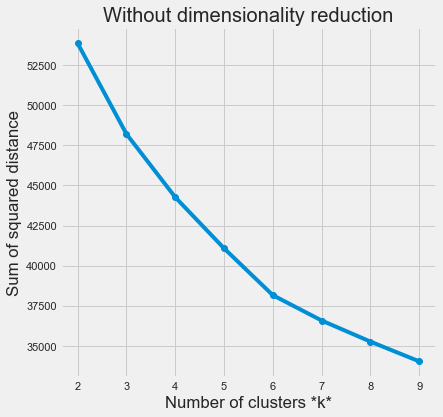

In [49]:
clustering_effectiveness()

__2) with dimensionality reduction (2 pca components)__

Silhouette score for 2 clusers:0.30596614583484005
Silhouette score for 3 clusers:0.14069511223395167
Silhouette score for 4 clusers:0.13111910080005465
Silhouette score for 5 clusers:0.09929174443184233
Silhouette score for 6 clusers:0.08454037602150374
Silhouette score for 7 clusers:0.07400517148390987
Silhouette score for 8 clusers:0.06880627619668946
Silhouette score for 9 clusers:0.057977631172521214


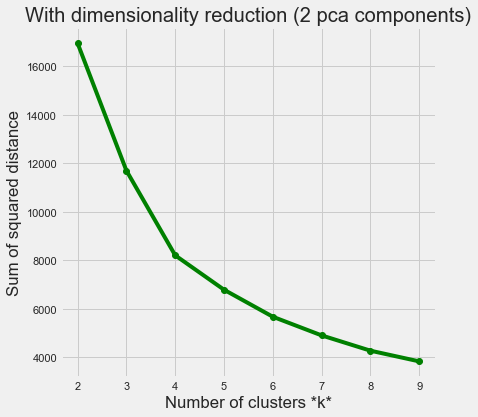

In [50]:
clustering_effectiveness_pca(n_components=2, color='green')

__3) with dimensionality reduction (3 pca components)__

Silhouette score for 2 clusers:0.3063976746484435
Silhouette score for 3 clusers:0.14052796431102466
Silhouette score for 4 clusers:0.13109399956201354
Silhouette score for 5 clusers:0.12570547156133377
Silhouette score for 6 clusers:0.11173811935921109
Silhouette score for 7 clusers:0.09928151764772174
Silhouette score for 8 clusers:0.09389351671208965
Silhouette score for 9 clusers:0.08493680901016341


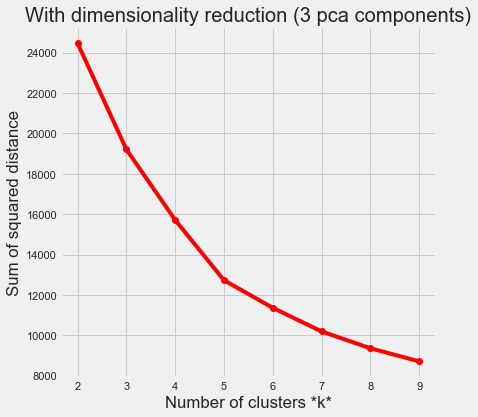

In [51]:
clustering_effectiveness_pca(n_components=3, color='red')

__4) 7 pca components__

Silhouette score for 2 clusers:0.30980317174137456
Silhouette score for 3 clusers:0.144523834880758
Silhouette score for 4 clusers:0.13448816687366105
Silhouette score for 5 clusers:0.13385036733559147
Silhouette score for 6 clusers:0.1329123401096335
Silhouette score for 7 clusers:0.13202491294504695
Silhouette score for 8 clusers:0.1218099001206602
Silhouette score for 9 clusers:0.1208154551116943


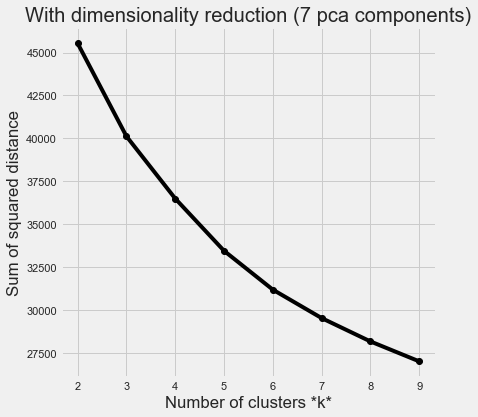

In [52]:
clustering_effectiveness_pca(n_components=7, color='black')

## Try different  number of clusters and pca components and analyze results

### 3 clusters; 3 pca components

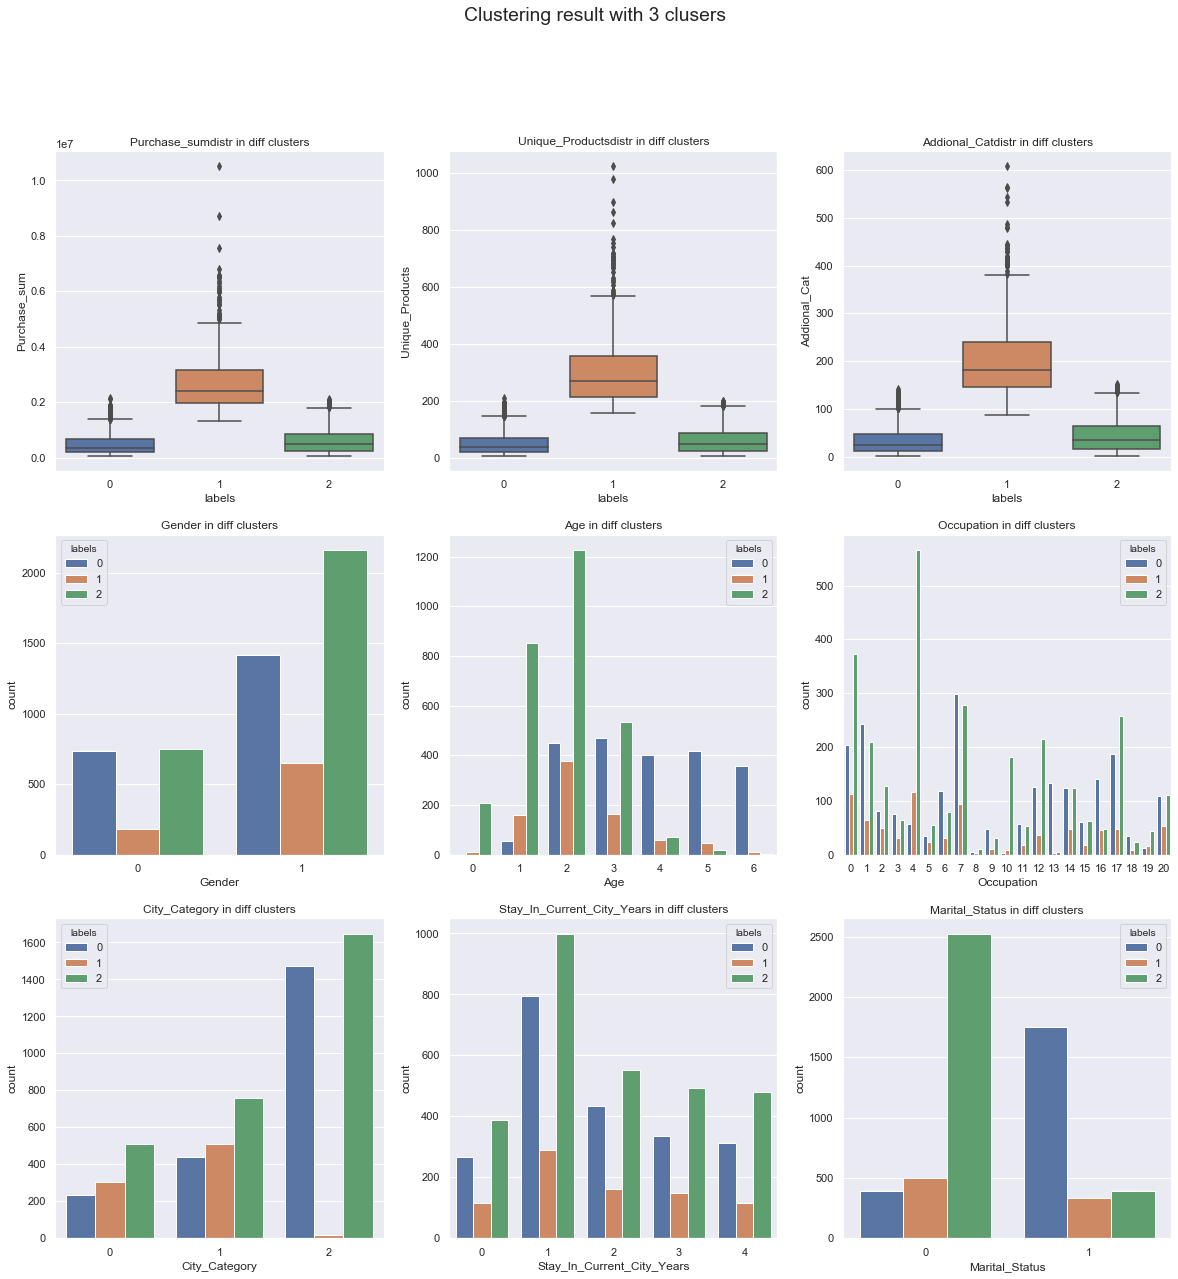

In [26]:
try_diff_cluster_num_and_pca_component(n_clusters=3, n_components=3)

###  4 clusters; 3 pca components

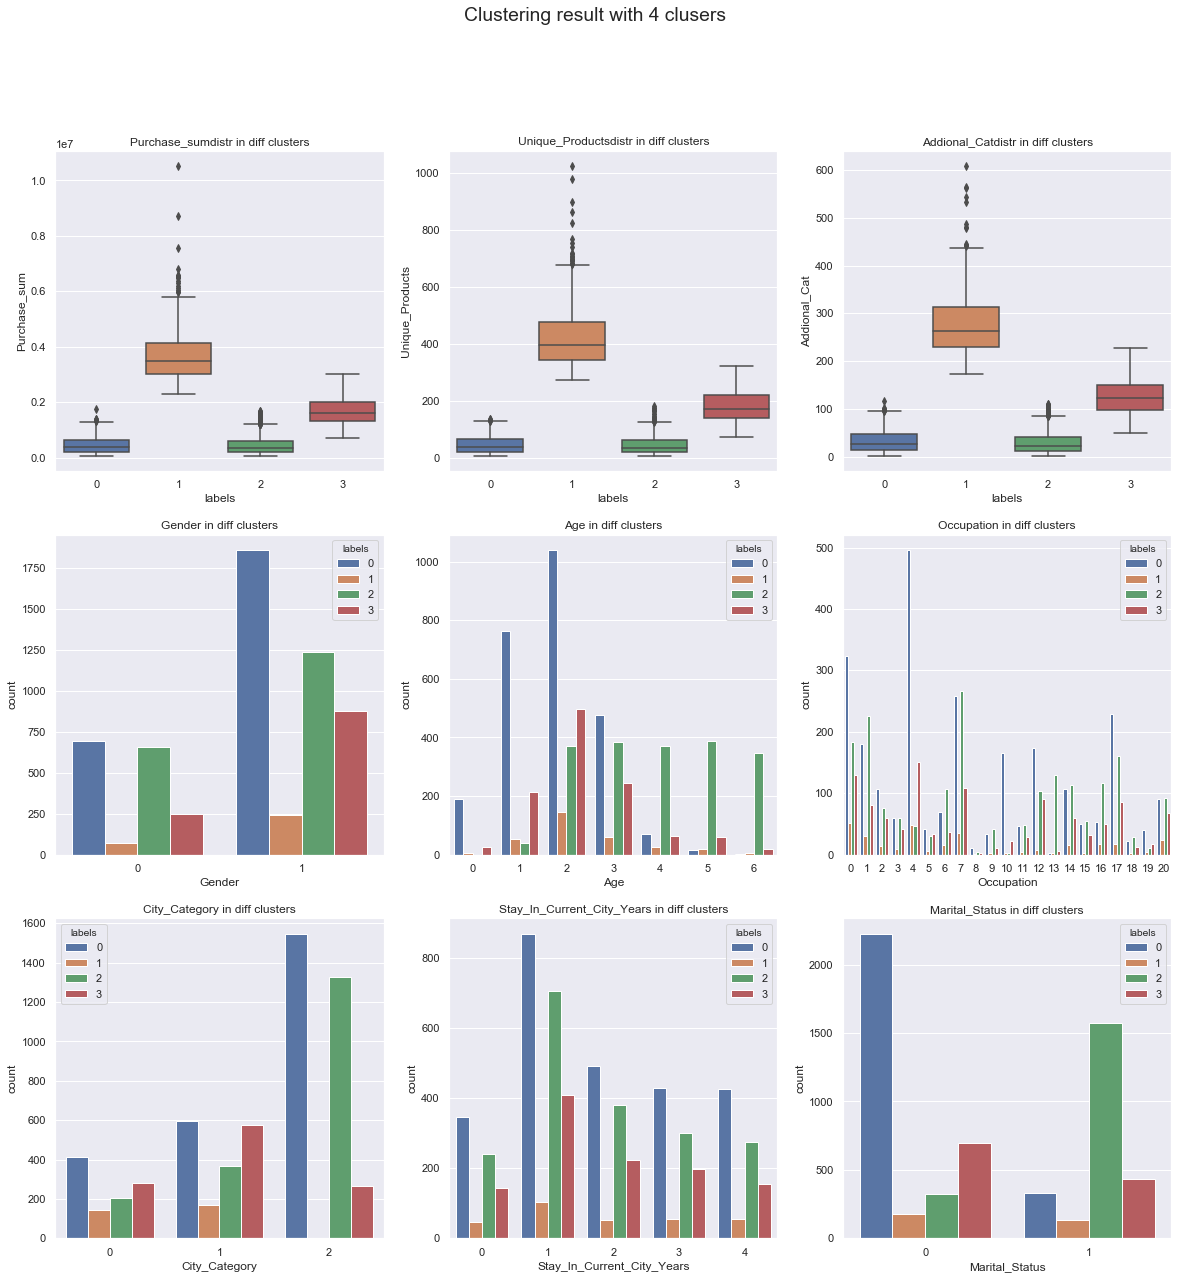

In [27]:
try_diff_cluster_num_and_pca_component(n_clusters=4, n_components=3)

### 5 clusters; 3 pca components

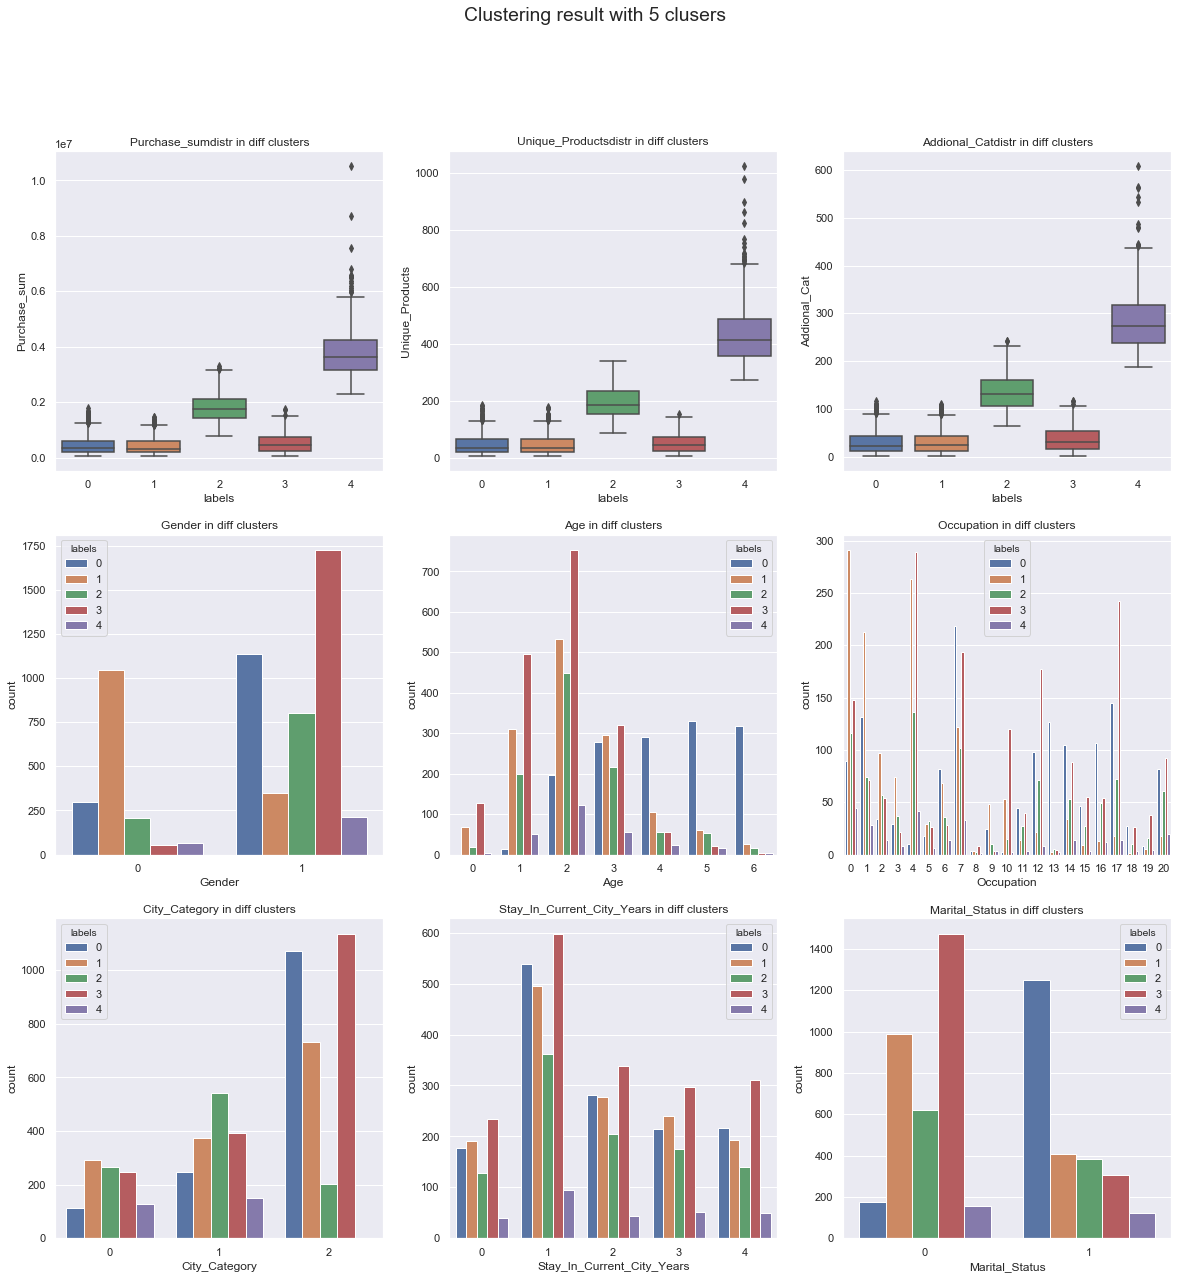

In [28]:
try_diff_cluster_num_and_pca_component(n_clusters=5, n_components=3)

__with that 5 clusters occupation pattern difference can be seen; there is a difference in occupation preference in different clusters__

### 6 clusters; 3 pca components

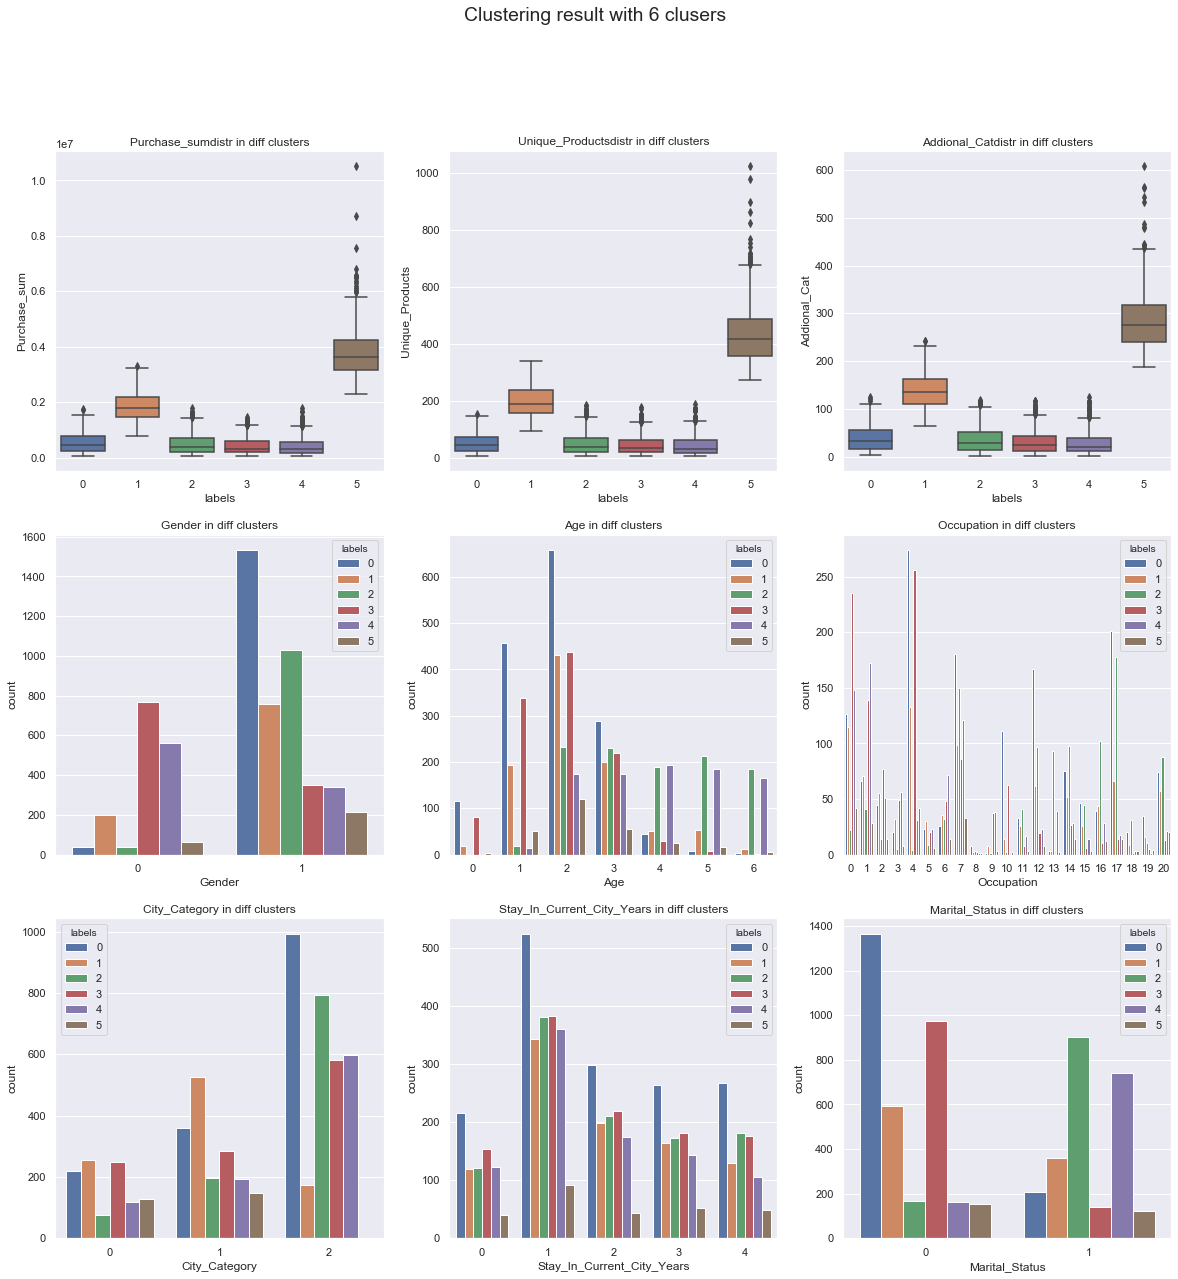

In [29]:
try_diff_cluster_num_and_pca_component(n_clusters=6, n_components=3)

###  2 clusters; 3 pca components

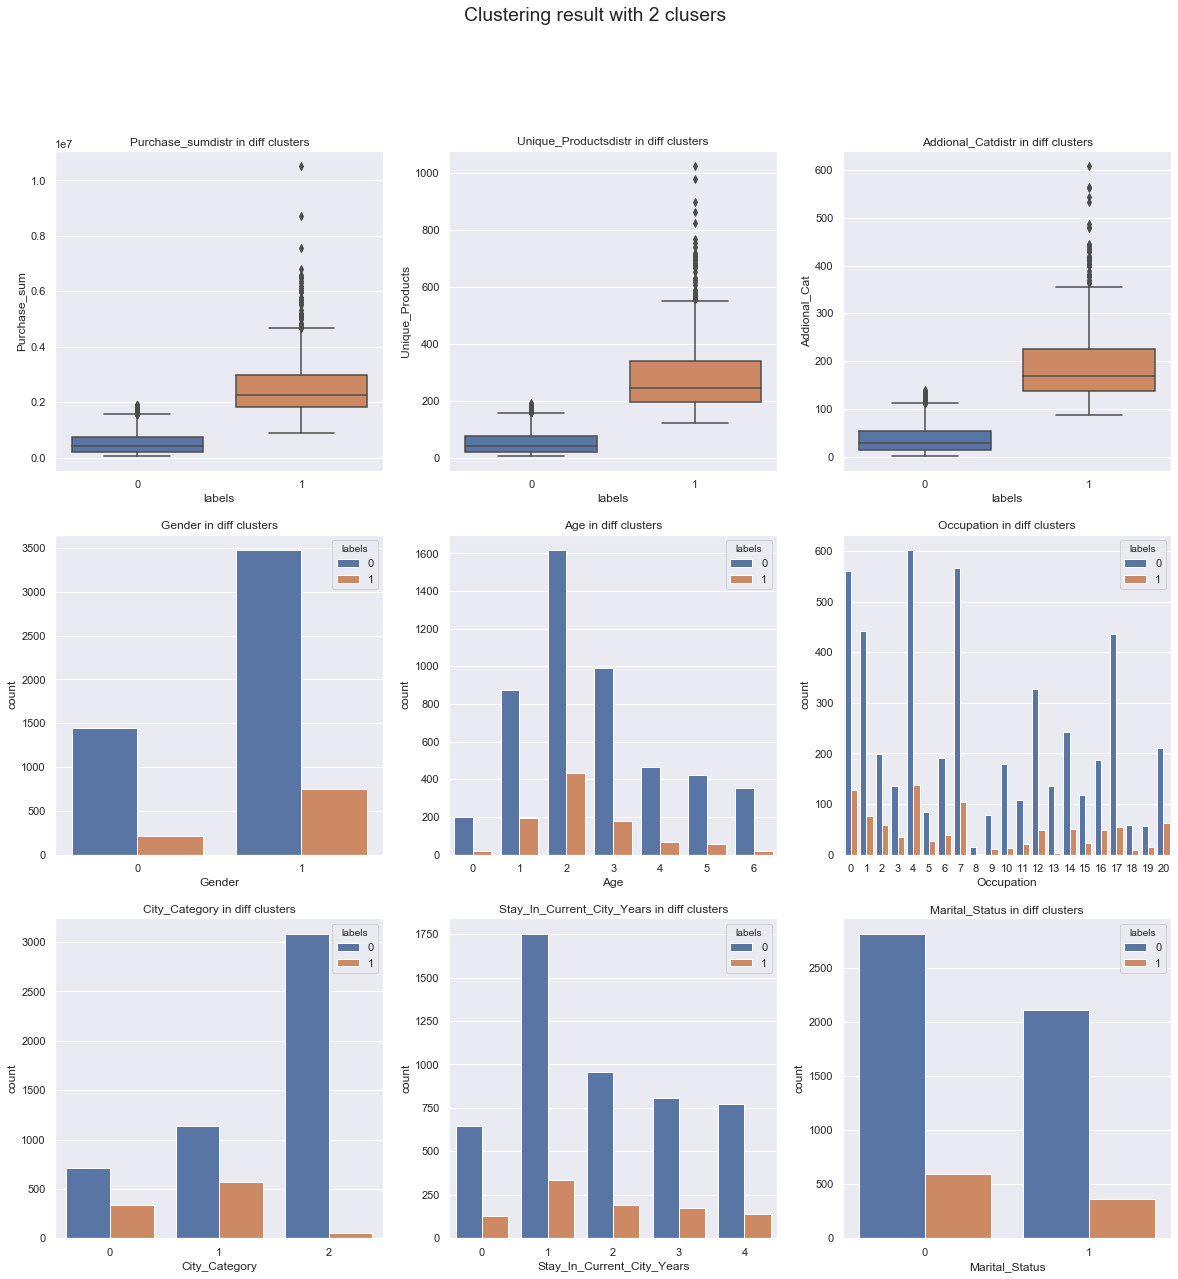

In [30]:
try_diff_cluster_num_and_pca_component(n_clusters=2, n_components=3)

### 2 clusters; 2 pca components

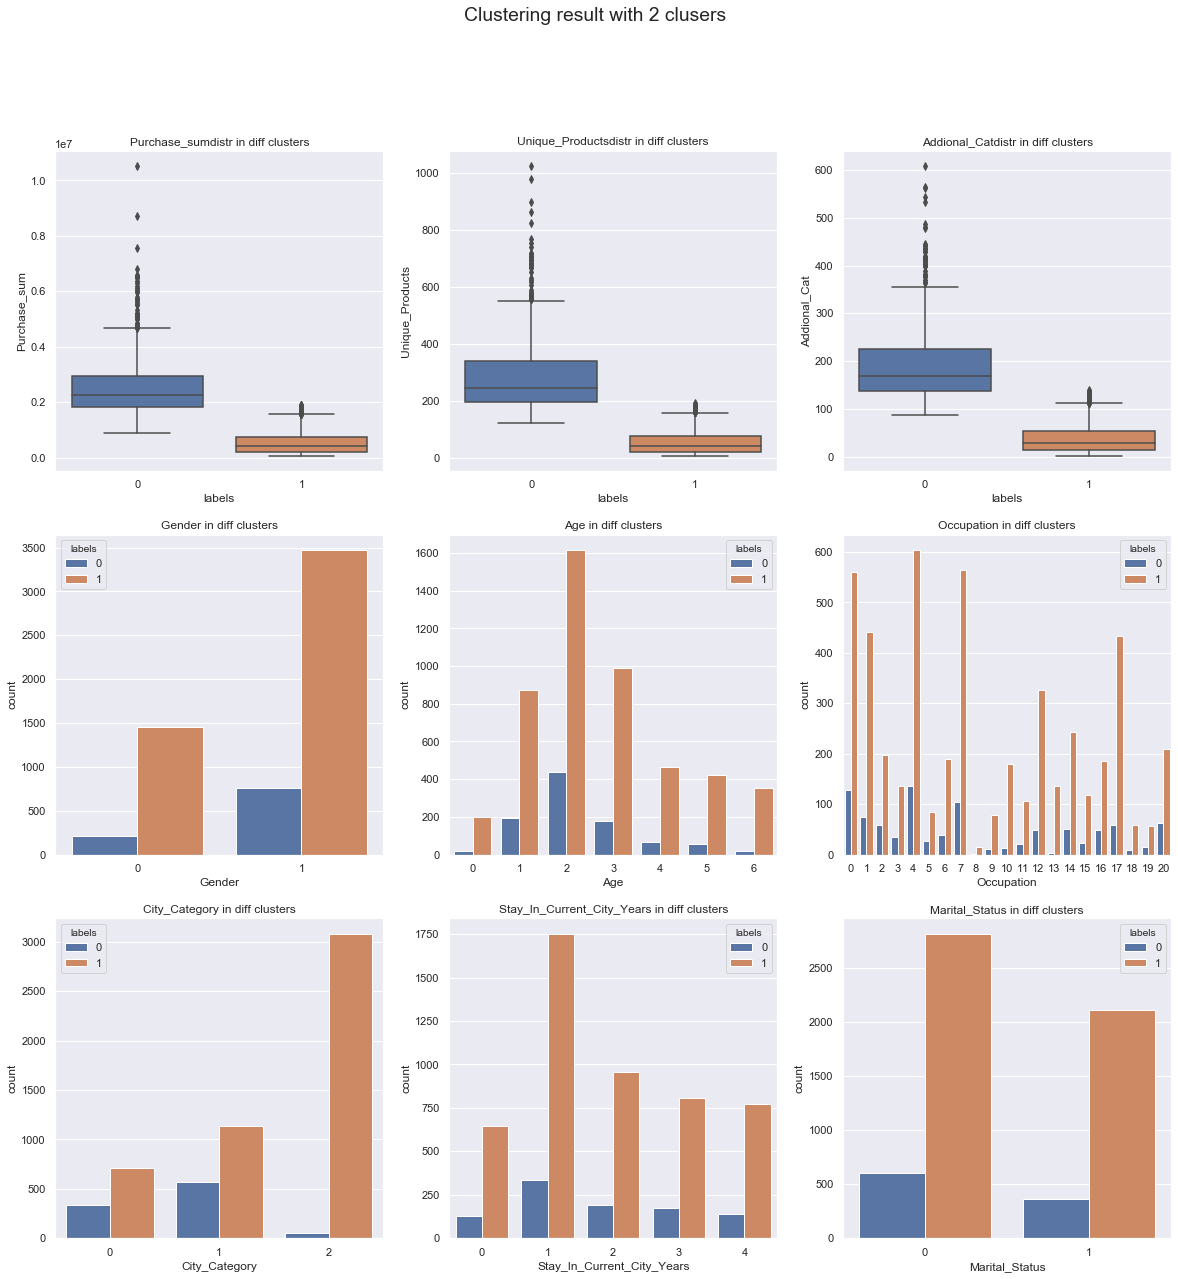

In [31]:
try_diff_cluster_num_and_pca_component(n_clusters=2, n_components=2)

### 3 clusters; 2 pca components

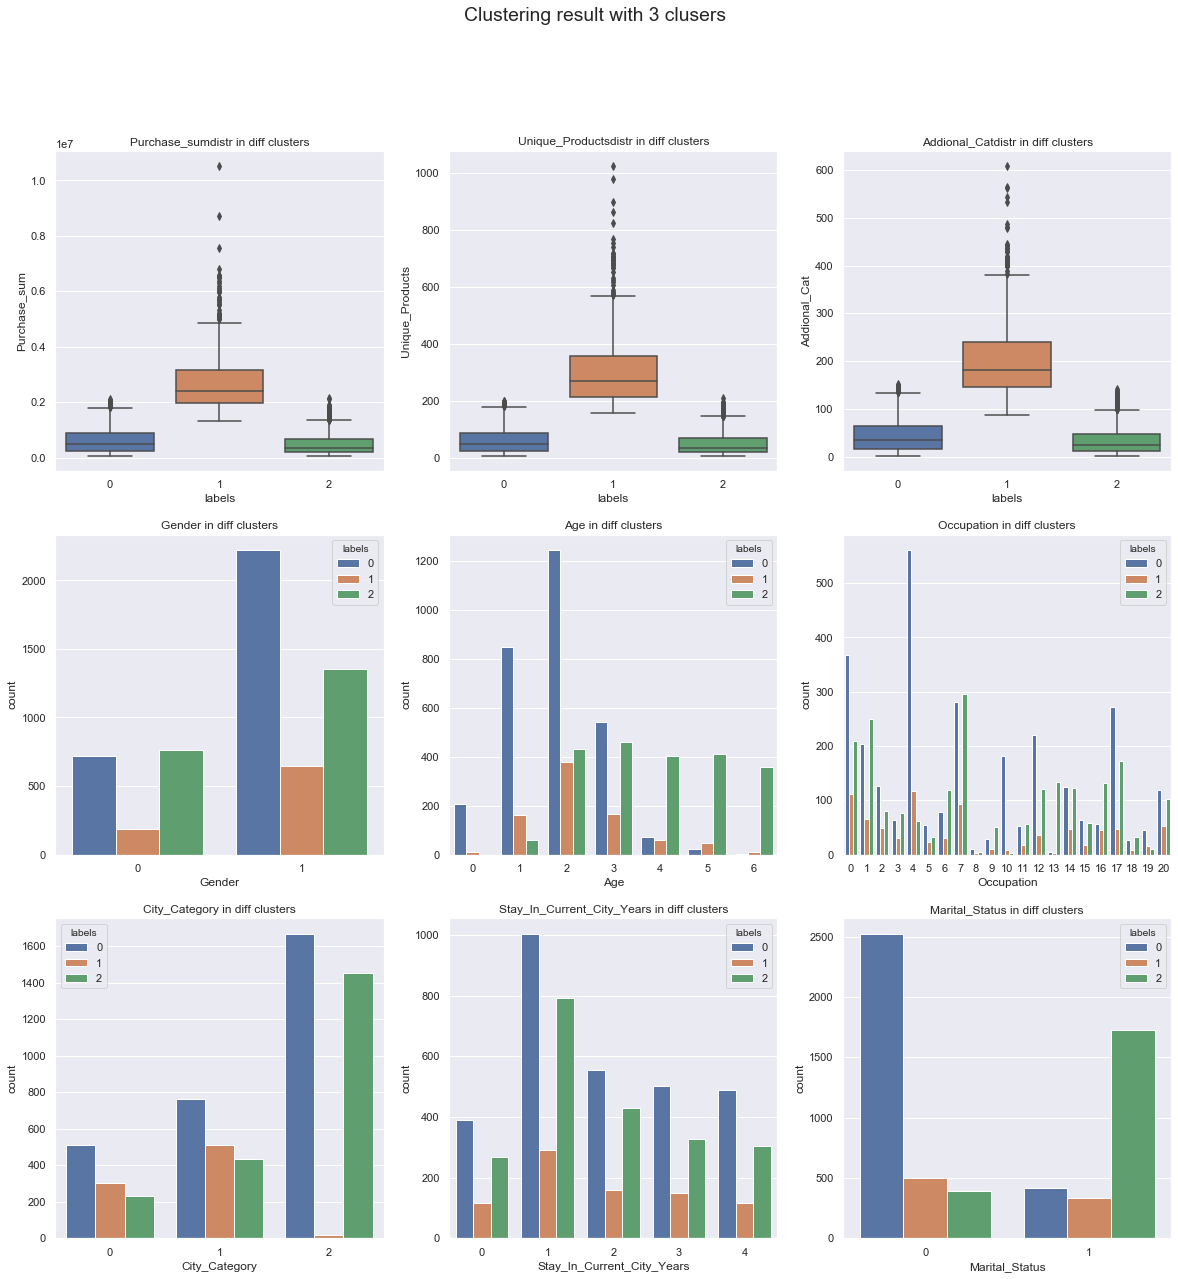

In [32]:
try_diff_cluster_num_and_pca_component(n_clusters=3, n_components=2)

### 4 clusters; 2 pca components

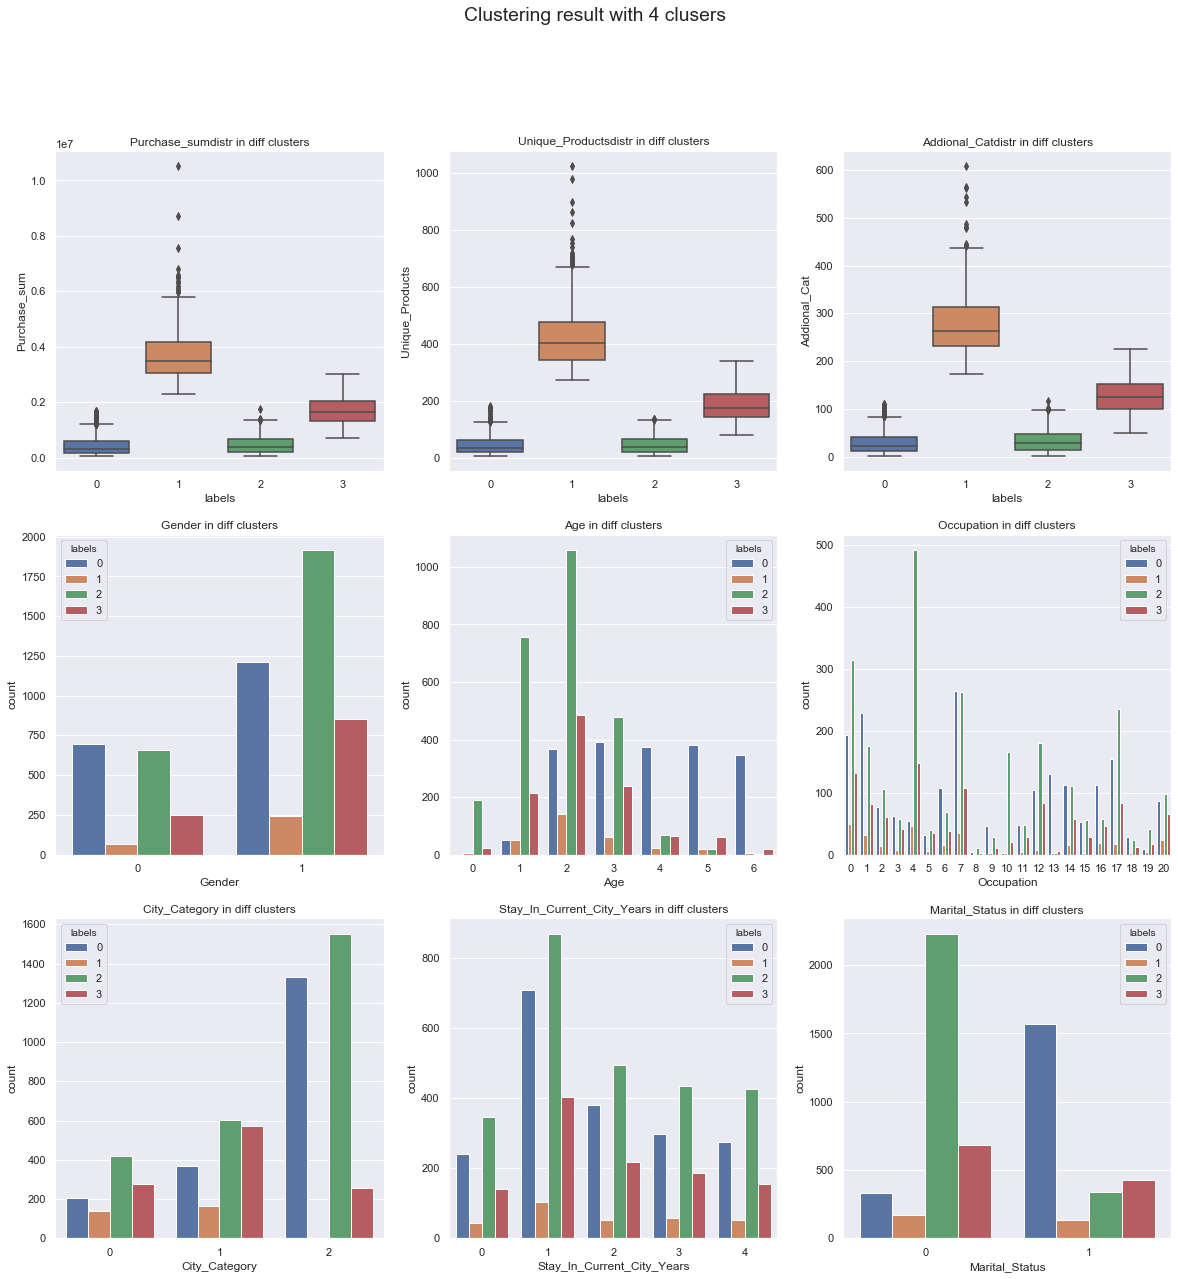

In [33]:
try_diff_cluster_num_and_pca_component(n_clusters=4, n_components=2)

###  5 clusters; 2 pca components

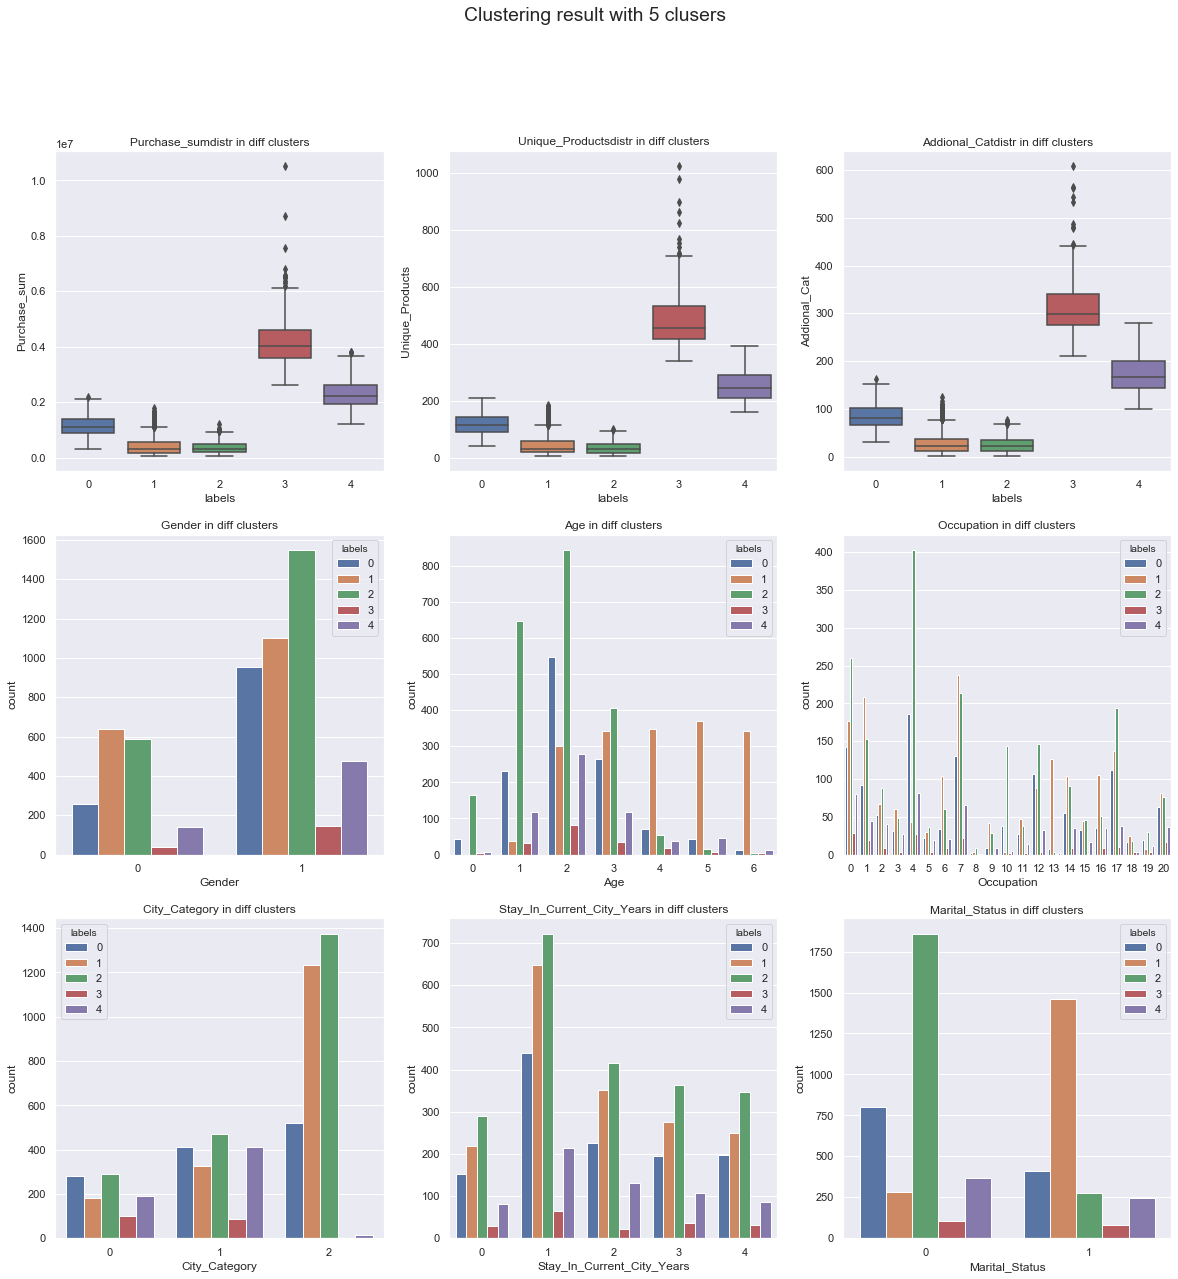

In [34]:
try_diff_cluster_num_and_pca_component(n_clusters=5, n_components=2)

### 6 clusters; 2 pca components

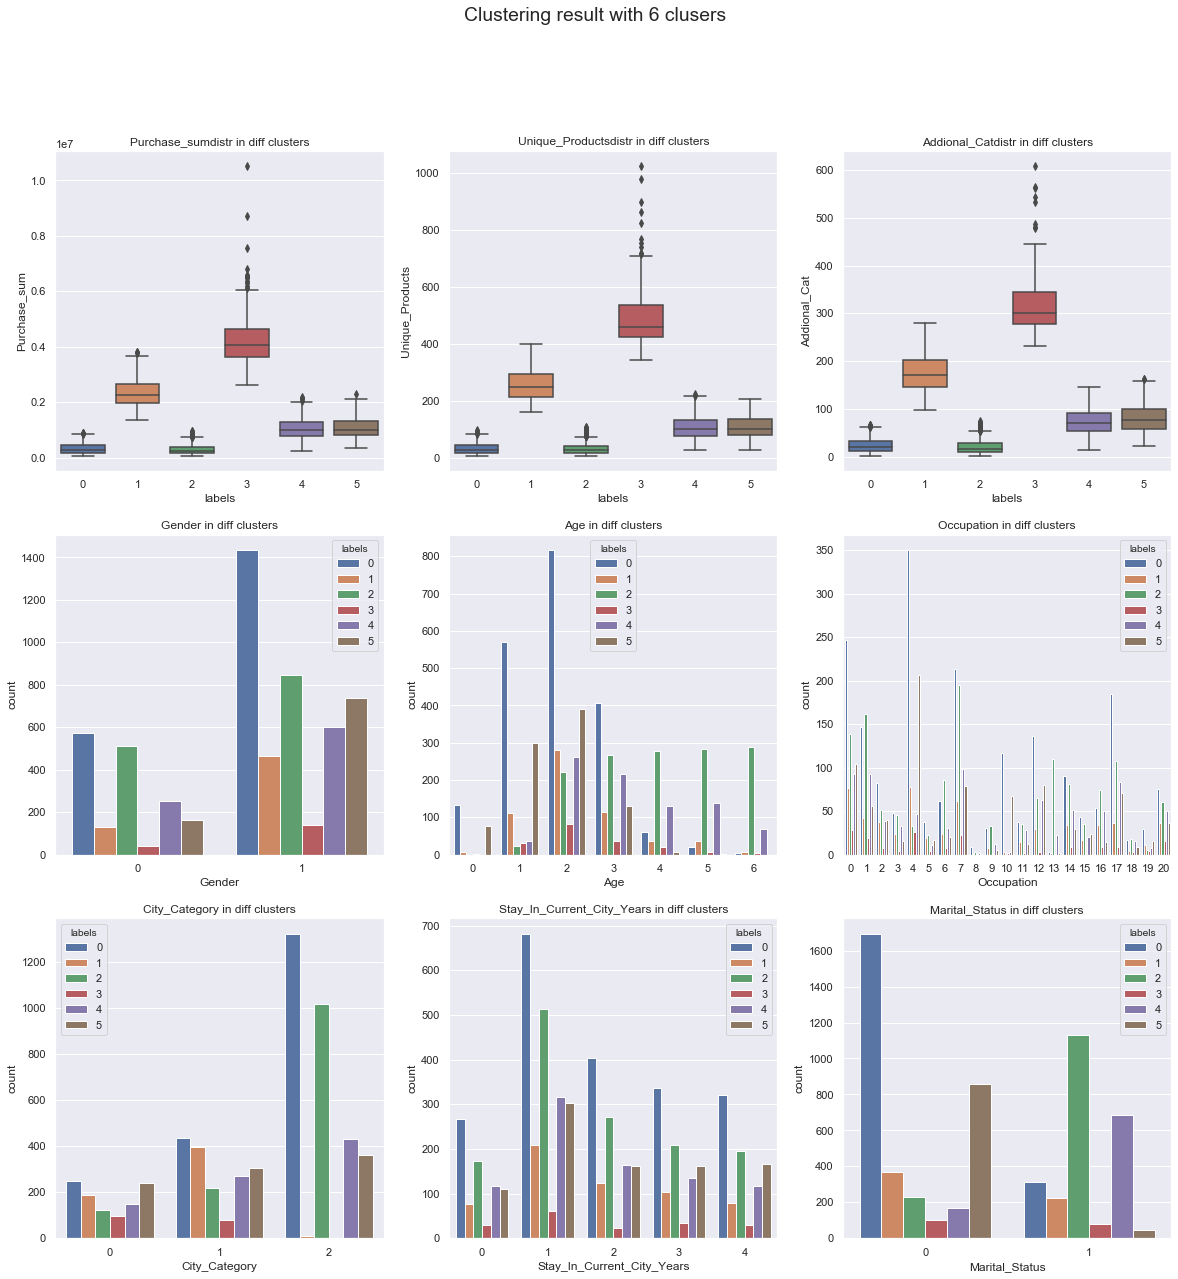

In [35]:
try_diff_cluster_num_and_pca_component(n_clusters=6, n_components=2)

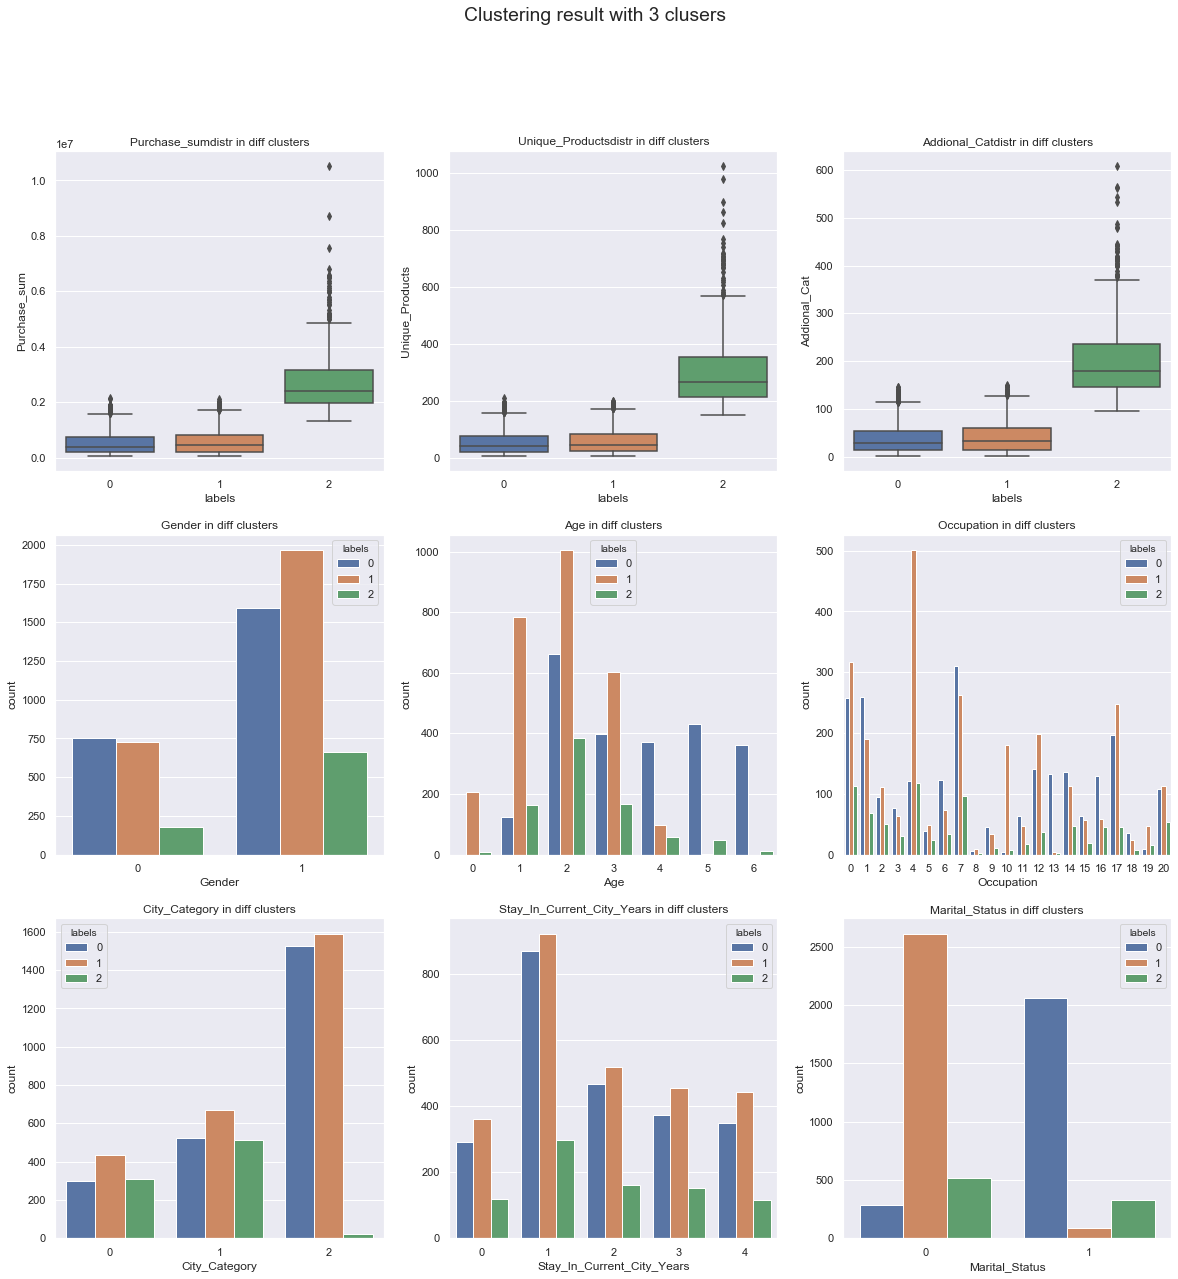

In [36]:
try_diff_cluster_num_and_pca_component(n_clusters=3, n_components=7)

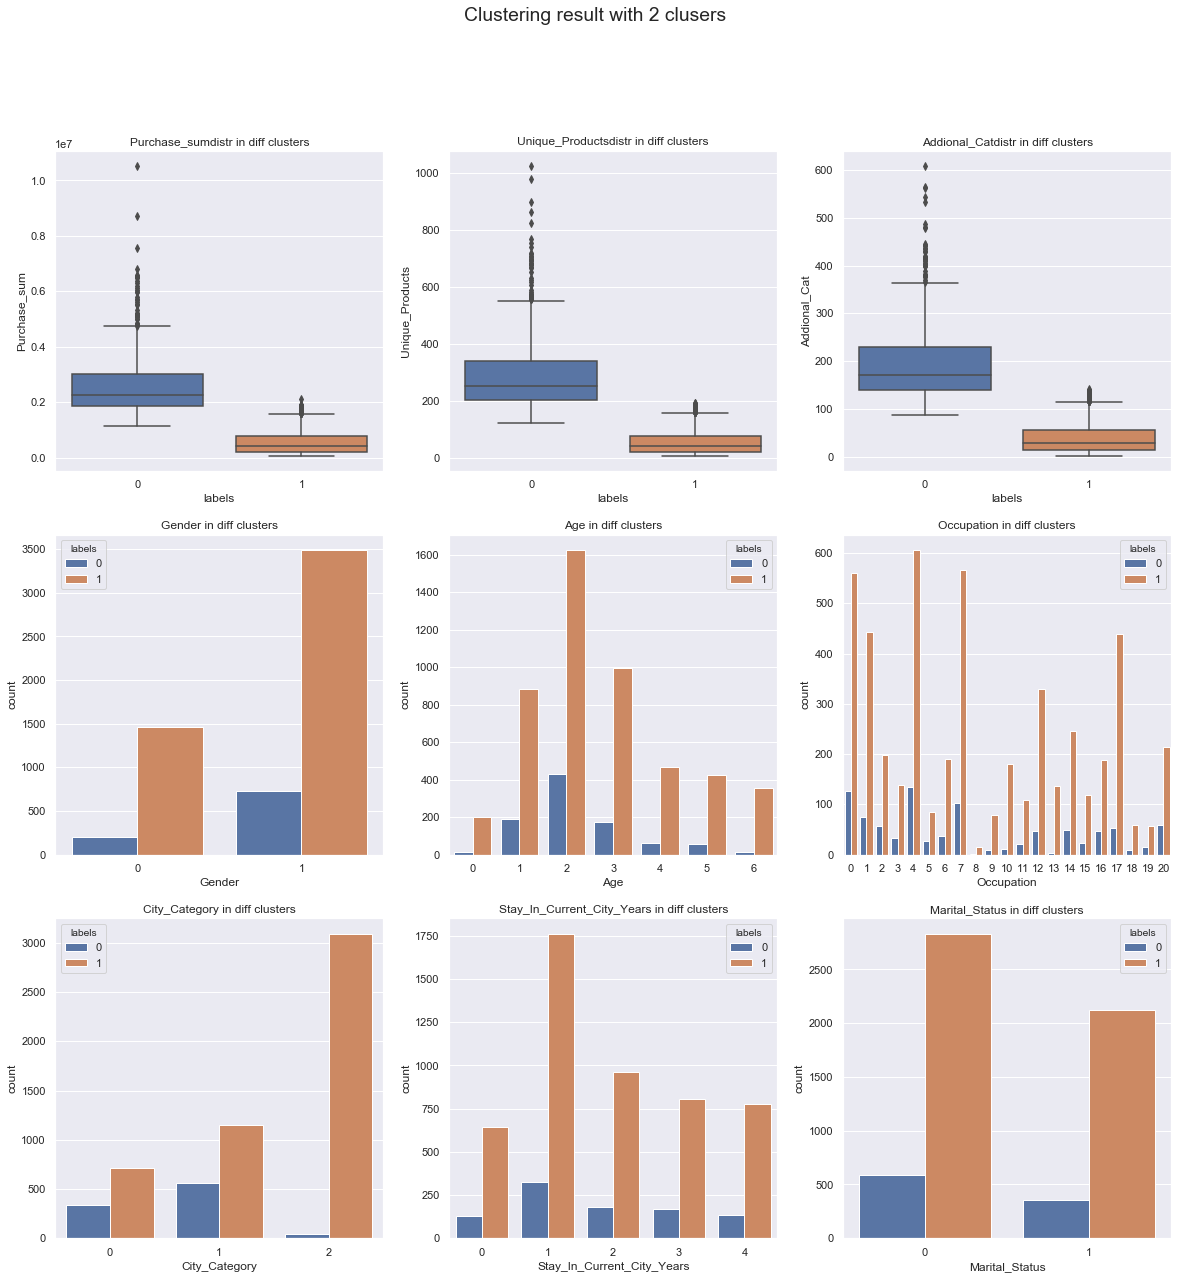

In [37]:
try_diff_cluster_num_and_pca_component(n_clusters=2, n_components=7)

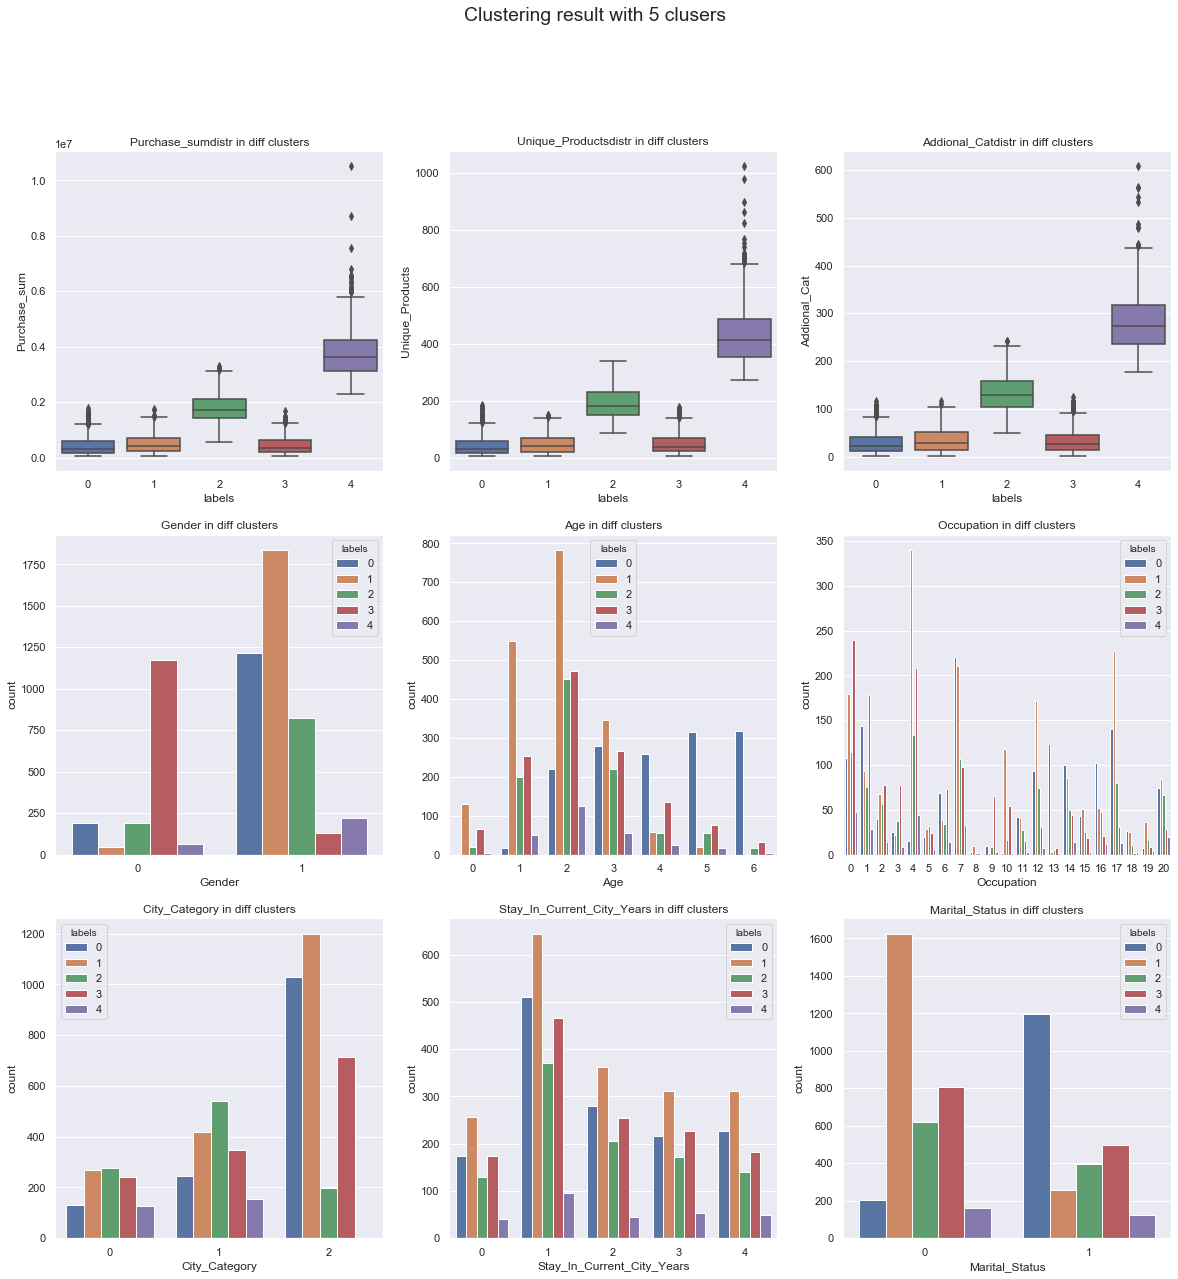

In [38]:
try_diff_cluster_num_and_pca_component(n_clusters=5, n_components=7)

## 2D Visualizations

In [39]:
def visualize_2d_clustering(n_clusters, ax):
    plt.style.use('fivethirtyeight')
    X_ = pca(2)
    results = do_clustering(n_clusters, c=2)
    labels = results[0] 
    centroids = results[2]
    ax.scatter(X_[:, 0], X_[:, 1], c=labels)
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    return ax

def full_visualization_2d_clustering(): 
    fig, axs = plt.subplots(3,2, figsize=(15,15))
    
    clusters = list(range(2, 8))
    
    for i, ax in enumerate(fig.axes): 
        ax = visualize_2d_clustering(clusters[i], ax)
        ax.set_title("%d clusters" % clusters[i])
    
    plt.show()
    

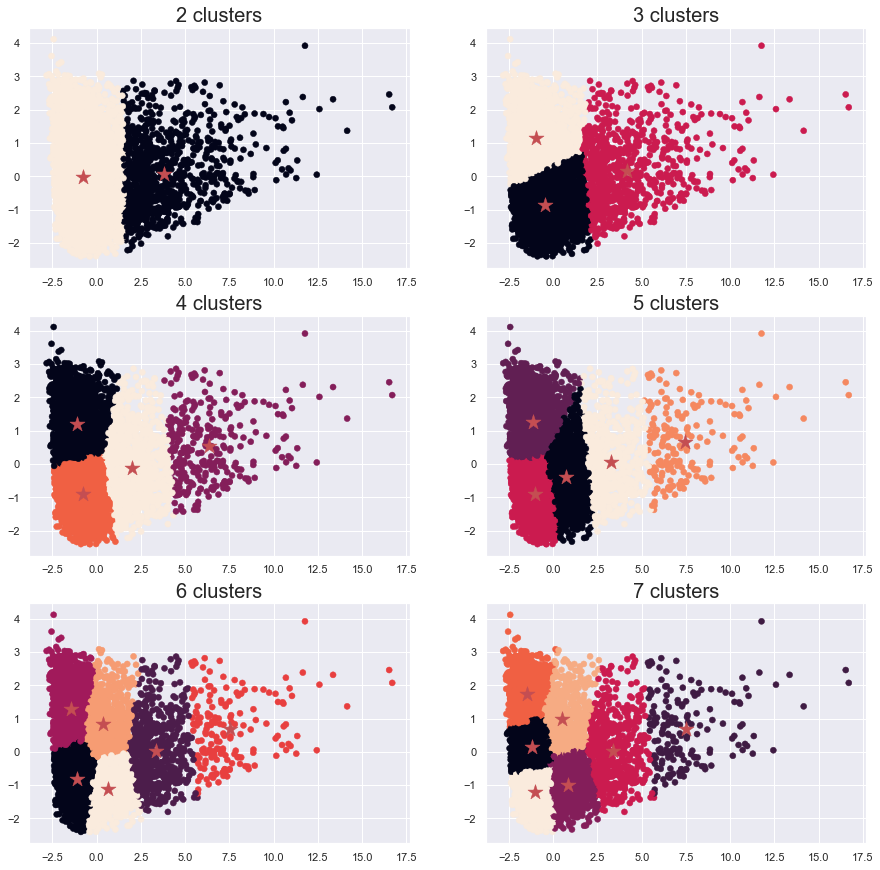

In [40]:
full_visualization_2d_clustering()

## 3D visualizations

In [41]:
# for interactive visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

In [42]:
def visualization_of_clusters(n_clusters):
    results = do_clustering(n_clusters, c=3)
    labels = results[0]
    X_ = pca(3)
    users['labels'] = labels
    trace1 = go.Scatter3d(
            x= X_[:, 0],
            y= X_[:, 1],
            z= X_[:, 2],
            mode='markers', 
            marker=dict(
        color = users['labels'], 
        size= 10,
        line=dict(
            color= users['labels'],
            width= 12
        ),
        opacity=0.8
        )
     )

    df = [trace1]

    layout = go.Layout(title = 'Black Friday clustering',
                   margin=dict(
          l=0,
          r=0,
           b=0,
           t=0  
       ),
        scene = dict(
            xaxis = dict(title  = 'pca_1'),
            yaxis = dict(title  = 'pca_2'),
            zaxis = dict(title  = 'pca_3')
        ))
    fig = go.Figure(data = df, layout = layout)
    py.iplot(fig)

### 2 clusters

In [43]:
visualization_of_clusters(n_clusters=2)

### 3 clusters

In [44]:
visualization_of_clusters(n_clusters=3)

### 4 clusters

In [45]:
visualization_of_clusters(n_clusters=4)

### 5 clusters

In [46]:
visualization_of_clusters(n_clusters=5)

### 6 clusters

In [47]:
visualization_of_clusters(n_clusters=6)